In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from assimilation_schemes import OI

plt.style.use('seaborn')

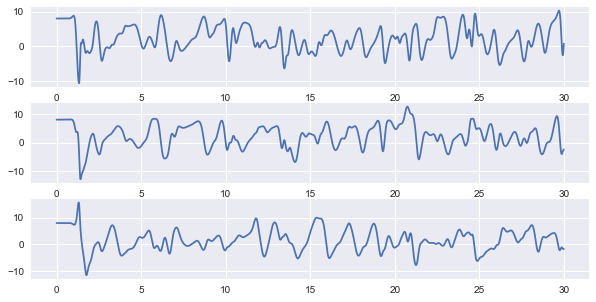

In [26]:
def lorenz96_fdm(ts, x0, F):
    dt = ts[1] - ts[0]
    x = np.zeros((x0.size, ts.size))
    x[:,0] = x0.ravel()
    
    for idx, time in enumerate(ts[1:]):
        xn = x[:,idx]
        xn_p1 = np.roll(xn, -1)  # x_{n+1}
        xn_m1 = np.roll(xn, 1)  # x_{n-1}
        xn_m2 = np.roll(xn, 2)  # x_{n-2}
        x[:,idx+1] = xn + dt * ((xn_p1-xn_m2) * xn_m1 - xn + F)
        
    return x

F = 8
ts = np.arange(0, 30, 0.01)
x0 = np.ones(40) * F
x0[19] += 0.01
X = lorenz96_fdm(ts, x0, F)

fig, axs = plt.subplots(nrows=3, figsize=(10, 5))
axs[0].plot(ts, X[0,:])
axs[1].plot(ts, X[1,:])
axs[2].plot(ts, X[2,:])

### Nature Run

In [51]:
seed = 42
rng = np.random.RandomState(seed)

N = 40  # number of variables
X_ini = rng.randint(0, 10, size=N)
X_ini

array([6, 3, 7, 4, 6, 9, 2, 6, 7, 4, 3, 7, 7, 2, 5, 4, 1, 7, 5, 1, 4, 0,
       9, 5, 8, 0, 9, 2, 6, 3, 8, 2, 4, 2, 6, 4, 8, 6, 1, 3])

In [52]:
F = 8
time = 30
dt = 0.01
ts = np.arange(0, time, dt)
X_nature = lorenz96_fdm(ts, X_ini, F)

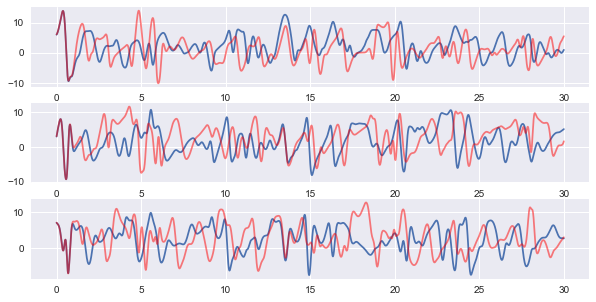

In [53]:
X_perturb_ini = X_ini + rng.rand(N) * 0.1
X_perturb = lorenz96_fdm(ts, X_perturb_ini, F)

fig, axs = plt.subplots(nrows=3, figsize=(10, 5))
for i in range(3):
    axs[i].plot(ts, X_nature[i,:])
    axs[i].plot(ts, X_perturb[i,:], color='red', alpha=0.5)

### Initial condition

In [54]:
X_ini = X_perturb_ini
X_ini

array([6.09422018, 3.05632882, 7.03854165, 4.00159663, 6.02308938,
       9.02410255, 2.06832635, 6.06099967, 7.08331949, 4.01733647,
       3.03910606, 7.01822361, 7.07553614, 2.04251559, 5.02079417,
       4.05677003, 1.00313133, 7.08422848, 5.04497541, 1.03951502,
       4.09266589, 0.0727272 , 9.03265408, 5.0570444 , 8.05208343,
       0.0961172 , 9.08445338, 2.07473201, 6.05396921, 3.05867512,
       8.09652553, 2.06070342, 4.02759992, 2.02962735, 6.01652669,
       4.00156364, 8.04234015, 6.03948815, 1.02934882, 3.00140798])

### Simulated Obs

In [55]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

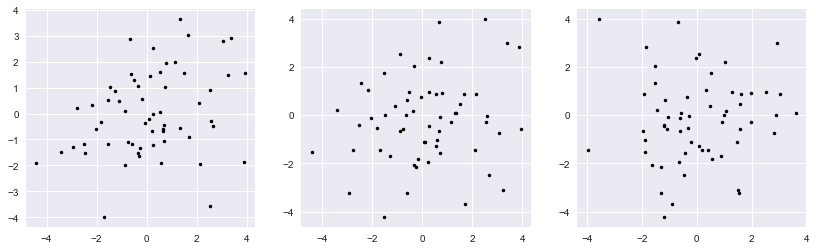

In [56]:
# observation parameters for each variables
obs_mean = [0 for i in range(N)]
obs_var = [3 for i in range(N)]
random_state = [i for i in range(N)]

# assimilate observation parameters
obs_timeintv = 0.5
cycle_num = int(time / obs_timeintv)

# construct observation error
X_obs_err = np.zeros((N, cycle_num))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_normal(obsm, obsv, cycle_num, rst)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

# plot observation errors
fig, axs = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
axs[0].plot(X_obs_err[0], X_obs_err[1], 'k.')
axs[1].plot(X_obs_err[0], X_obs_err[2], 'k.')
axs[2].plot(X_obs_err[1], X_obs_err[2], 'k.')

### NMC